In [1]:
import numpy as np

In [2]:
A = np.matrix([
    [0, 1, 0, 0],
    [0, 0, 1, 1], 
    [0, 1, 0, 0],
    [1, 0, 1, 0]],
    dtype=float
)

In [3]:
X = np.matrix([
            [i, -i]
            for i in range(A.shape[0])
        ], dtype=float)

In [4]:
# The representation of each node (each row) is now a sum of its neighbors features!
# however it does not include the features from the node itself, unless there is a self loop
A * X

matrix([[ 1., -1.],
        [ 5., -5.],
        [ 1., -1.],
        [ 2., -2.]])

In [5]:
# Adding Self-Loops: The aggregated representation of a node does not include its own features! 
# The representation is an aggregate of the features of neighbor nodes,
# so only nodes that has a self-loop will include their own features in the aggregate.
I = np.matrix(np.eye(A.shape[0]))
A_hat = A + I
A_hat * X

matrix([[ 1., -1.],
        [ 6., -6.],
        [ 3., -3.],
        [ 5., -5.]])

In [6]:
# Normalizing the Feature Representations
# Nodes with large degrees will have large values in their feature representation while
# nodes with small degrees will have small values.
# This can cause vanishing or exploding gradients
# node representations corresponding to the mean of the features of neighboring nodes. 
# This is because the weights in the (transformed) adjacency matrix correspond to weights in 
# a weighted sum of the neighboring nodes’ features.
# notice sum of each row = 1

D_hat = np.array(np.sum(A_hat, axis=0))[0]
D_hat = np.matrix(np.diag(D_hat))
print("A:\n",  A)
print("A_hat:\n", A_hat)
print("D_hat:\n", D_hat)

D_hat**-1 * A_hat

A:
 [[0. 1. 0. 0.]
 [0. 0. 1. 1.]
 [0. 1. 0. 0.]
 [1. 0. 1. 0.]]
A_hat:
 [[1. 1. 0. 0.]
 [0. 1. 1. 1.]
 [0. 1. 1. 0.]
 [1. 0. 1. 1.]]
D_hat:
 [[2. 0. 0. 0.]
 [0. 3. 0. 0.]
 [0. 0. 3. 0.]
 [0. 0. 0. 2.]]


matrix([[0.5       , 0.5       , 0.        , 0.        ],
        [0.        , 0.33333333, 0.33333333, 0.33333333],
        [0.        , 0.33333333, 0.33333333, 0.        ],
        [0.5       , 0.        , 0.5       , 0.5       ]])

## Putting it All Together

In [7]:
W = np.matrix([
             [1, -1],
             [-1, 1]
         ])

pre_activation_layer_1 = D_hat**-1 * A_hat * X * W
print(pre_activation_layer_1)

[[ 1. -1.]
 [ 4. -4.]
 [ 2. -2.]
 [ 5. -5.]]


In [8]:
def relu(x):
    if x < 0 :
        return 0
    else:
        return x
    
    
relu_vec = np.vectorize(relu)
result = relu_vec(pre_activation_layer_1)
result

matrix([[1., 0.],
        [4., 0.],
        [2., 0.],
        [5., 0.]])

## Zachary’s Karate Club

In [9]:
from networkx import karate_club_graph, to_numpy_matrix

zkc = karate_club_graph()

order = sorted(list(zkc.nodes()))
A = to_numpy_matrix(zkc, nodelist=order)
I = np.eye(zkc.number_of_nodes())
A_hat = A + I
D_hat = np.array(np.sum(A_hat, axis=0))[0]
D_hat = np.matrix(np.diag(D_hat))

In [10]:
W_1 = np.random.normal(
    loc=0, scale=1, size=(zkc.number_of_nodes(), 4))
W_2 = np.random.normal(
    loc=0, size=(W_1.shape[1], 2))

In [11]:
def gcn_layer(A_hat, D_hat, X, W, activate = True):
    if activate:
        return relu_vec(D_hat**-1 * A_hat * X * W)
    else:
        return D_hat**-1 * A_hat * X * W


H_1 = gcn_layer(A_hat, D_hat, I, W_1, False)
H_2 = gcn_layer(A_hat, D_hat, H_1, W_2, False)
output = H_2
print(H_2)

[[ 0.27810459  0.03475642]
 [ 0.29077573  0.05744313]
 [ 0.40676551 -0.11097527]
 [ 0.37036087 -0.0616709 ]
 [ 0.00213726  0.19078272]
 [-0.20550754  0.18407716]
 [-0.07310335  0.12406585]
 [ 0.44759386 -0.06190154]
 [ 0.57402437 -0.04818369]
 [ 0.68284001 -0.30939467]
 [ 0.22525672  0.12887706]
 [ 0.47478736  0.07188944]
 [ 0.38602811 -0.12395588]
 [ 0.53825609 -0.10866337]
 [ 0.87393709 -0.00514369]
 [ 0.95273627 -0.10476995]
 [-0.39757011  0.14072599]
 [ 0.05347004  0.06064475]
 [ 0.72477898  0.06031109]
 [ 0.56186728 -0.12167013]
 [ 1.01066398 -0.0814761 ]
 [ 0.0600942   0.26493266]
 [ 1.01998469 -0.03000815]
 [ 0.47834203 -0.20260374]
 [ 0.6116436  -0.33437742]
 [ 0.721737   -0.09106589]
 [ 0.68767978 -0.2817686 ]
 [ 0.67248427 -0.34018615]
 [ 1.01054523 -0.25395767]
 [ 0.63478461 -0.15929037]
 [ 0.48512021  0.0094001 ]
 [ 0.80540949 -0.24996777]
 [ 0.73965815  0.32892872]
 [ 0.6327913   0.17399056]]


In [12]:
feature_representations = {
    node: np.array(output)[node] 
    for node in zkc.nodes()}

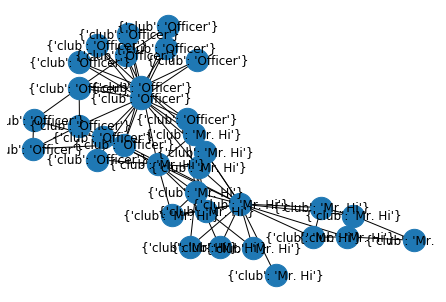

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx

def show_graph_with_labels(adjacency_matrix, mylabels = None):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=500, labels=mylabels, with_labels=True)
    plt.show()

show_graph_with_labels(A, zkc.nodes())

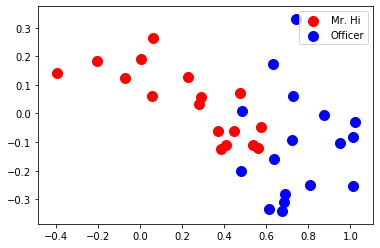

In [14]:
import numpy as np
from matplotlib import pyplot as plt

group = np.array([zkc.nodes()[i]['club'] for i in zkc.nodes()])
cdict = {'Mr. Hi': 'red', 'Officer': 'blue'}

def extract_array(output, ix, element = 0):
    out = np.array([output[i][0,element] for i in ix[0]])
    return out



fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(extract_array(output, ix, element = 0), extract_array(output, ix, element = 1), c = cdict[g], label = g, s = 100)
ax.legend()
plt.show()

# Semi Supervised Learning

In [22]:
from collections import namedtuple
from networkx import read_edgelist, set_node_attributes
from pandas import read_csv, Series
from numpy import array

DataSet = namedtuple(
    'DataSet',
    field_names=['X_train', 'y_train', 'X_test', 'y_test', 'network']
)

def load_karate_club():
    network = read_edgelist(
        'karate.edgelist',
        nodetype=int)

    attributes = read_csv(
        'karate.attributes.csv',
        index_col=['node'])

    for attribute in attributes.columns.values:
        set_node_attributes(
            network,
            values=Series(
                attributes[attribute],
                index=attributes.index).to_dict(),
            name=attribute
        )

    X_train, y_train = map(array, zip(*[
        ([node], data['role'] == 'Administrator')
        for node, data in network.nodes(data=True)
        if data['role'] in {'Administrator', 'Instructor'}
    ]))
    X_test, y_test = map(array, zip(*[
        ([node], data['community'] == 'Administrator')
        for node, data in network.nodes(data=True)
        if data['role'] == 'Member'
    ]))
    
    return DataSet(
        X_train, y_train,
        X_test, y_test,
        network)


In [23]:
from networkx import to_numpy_matrix, degree_centrality, betweenness_centrality, shortest_path_length
import mxnet.ndarray as nd

zkc = load_karate_club()

A = to_numpy_matrix(zkc.network)
A = nd.array(A)

X_train = zkc.X_train.flatten()
y_train = zkc.y_train
X_test = zkc.X_test.flatten()
y_test = zkc.y_test


In [18]:
#!/usr/bin/env python
# coding: utf-8

# # How to Do Deep Learning on Graphs with Graph Convolutional Networks
# ## Part 2: Semi-Supervised Learning with Spectral Graph Convolutions
# This notebook accompanies my Medium article with the above title for readers to try out and explore graph convolutional networks for themselves. You can find the article [here](https://towardsdatascience.com/how-to-do-deep-learning-on-graphs-with-graph-convolutional-networks-62acf5b143d0). To run the notebook, install the packages specified in the accompanying requirements.txt file.

# #  Load Karate Club

# In[1]:


from collections import namedtuple
from networkx import read_edgelist, set_node_attributes
from pandas import read_csv, Series
from numpy import array

DataSet = namedtuple(
    'DataSet',
    field_names=['X_train', 'y_train', 'X_test', 'y_test', 'network']
)

def load_karate_club():
    network = read_edgelist(
        'karate.edgelist',
        nodetype=int)

    attributes = read_csv(
        'karate.attributes.csv',
        index_col=['node'])

    for attribute in attributes.columns.values:
        set_node_attributes(
            network,
            values=Series(
                attributes[attribute],
                index=attributes.index).to_dict(),
            name=attribute
        )

    X_train, y_train = map(array, zip(*[
        ([node], data['role'] == 'Administrator')
        for node, data in network.nodes(data=True)
        if data['role'] in {'Administrator', 'Instructor'}
    ]))
    X_test, y_test = map(array, zip(*[
        ([node], data['community'] == 'Administrator')
        for node, data in network.nodes(data=True)
        if data['role'] == 'Member'
    ]))
    
    return DataSet(
        X_train, y_train,
        X_test, y_test,
        network)


# In[ ]:


from networkx import to_numpy_matrix, degree_centrality, betweenness_centrality, shortest_path_length
import mxnet.ndarray as nd

zkc = load_karate_club()

A = to_numpy_matrix(zkc.network)
A = nd.array(A)

X_train = zkc.X_train
y_train = zkc.y_train
X_test = zkc.X_test
y_test = zkc.y_test


# # Layer Implementations

# In[ ]:


from mxnet.gluon import HybridBlock
from mxnet.gluon.nn import Activation
import mxnet.ndarray as nd

class SpectralRule(HybridBlock):
    def __init__(self, A, in_units, out_units, activation='relu', **kwargs):
        super().__init__(**kwargs)
        I = nd.eye(*A.shape)
        A_hat = A.copy() + I

        D = nd.sum(A_hat, axis=0)
        D_inv = D**-0.5
        D_inv = nd.diag(D_inv)

        A_hat = D_inv * A_hat * D_inv
        
        self.in_units, self.out_units = in_units, out_units
        
        with self.name_scope():
            self.A_hat = self.params.get_constant('A_hat', A_hat)
            self.W = self.params.get(
                'W', shape=(self.in_units, self.out_units)
            )
            if activation == 'identity':
                self.activation = lambda X: X
            else:
                self.activation = Activation(activation)

    def hybrid_forward(self, F, X, A_hat, W):
        aggregate = F.dot(A_hat, X)
        propagate = self.activation(
            F.dot(aggregate, W))
        return propagate


# In[ ]:


class LogisticRegressor(HybridBlock):
    def __init__(self, in_units, **kwargs):
        super().__init__(**kwargs)
        with self.name_scope():
            self.w = self.params.get(
                'w', shape=(1, in_units)
            )

            self.b = self.params.get(
                'b', shape=(1, 1)
            )

    def hybrid_forward(self, F, X, w, b):
        # Change shape of b to comply with MXnet addition API
        b = F.broadcast_axis(b, axis=(0,1), size=(34, 1))
        y = F.dot(X, w, transpose_b=True) + b

        return F.sigmoid(y)


# # Models

# In[ ]:


from mxnet.gluon.nn import HybridSequential, Activation
from mxnet.ndarray import array
from mxnet.initializer import One, Uniform, Xavier
from mxnet.gluon.loss import SigmoidBinaryCrossEntropyLoss

def build_features(A, X):
    hidden_layer_specs = [(4, 'tanh'), (2, 'tanh')] # Format: (units in layer, activation function)
    in_units = in_units=X.shape[1]
  
    features = HybridSequential()
    with features.name_scope():
        for i, (layer_size, activation_func) in enumerate(hidden_layer_specs):
            layer = SpectralRule(
                A, in_units=in_units, out_units=layer_size, 
                activation=activation_func)
            features.add(layer)

            in_units = layer_size
    return features, in_units



def build_model(A, X):
    model = HybridSequential()
    hidden_layer_specs = [(4, 'tanh'), (2, 'tanh')]
    in_units = X.shape[1]

    with model.name_scope():
        features, out_units = build_features(A, X)
        model.add(features)

        classifier = LogisticRegressor(out_units)
        model.add(classifier)

    model.hybridize()
    model.initialize(Uniform(1))

    return model, features


# ## Model 1: Identity Matrix as Features

# In[ ]:


X_1 = I = nd.eye(*A.shape)
model_1, features_1 = build_model(A, X_1)
model_1(X_1)


# ## Model 2: Distance to Administrator and Instructor as Additional Features

# In[ ]:


X_2 = nd.zeros((A.shape[0], 2))
node_distance_instructor = shortest_path_length(zkc.network, target=33)
node_distance_administrator = shortest_path_length(zkc.network, target=0)

for node in zkc.network.nodes():
    X_2[node][0] = node_distance_administrator[node]
    X_2[node][1] = node_distance_instructor[node]


# In[ ]:


X_2 = nd.concat(X_1, X_2)
model_2, features_2 = build_model(A, X_2)
model_2(X_2)


# # Train and Test Models

# In[ ]:


get_ipython().run_line_magic('time', '')
from mxnet import autograd
from mxnet.gluon import Trainer
from mxnet.ndarray import sum as ndsum
import numpy as np

def train(model, features, X, X_train, y_train, epochs):
    cross_entropy = SigmoidBinaryCrossEntropyLoss(from_sigmoid=True)
    trainer = Trainer(model.collect_params(), 'sgd', {'learning_rate': 0.001, 'momentum': 1})

    feature_representations = [features(X).asnumpy()]
    
#     model = model.copyto(gpu(0))
#     X = X.copyto(gpu(0))
#     X_train = X_train.copyto(gpu(0))
#     y_train = y_train.copyto(gpu(0))
    
    for e in range(1, epochs + 1):
        cum_loss = 0
        cum_preds = []

        for i, x in enumerate(X_train.flatten()):
            y = array(y_train)[i]
            with autograd.record():
                preds = model(X)[x]
                loss = cross_entropy(preds, y)
            loss.backward()
            trainer.step(1)

            cum_loss += loss.asscalar()
            cum_preds += [preds.asscalar()]

        feature_representations.append(features(X).asnumpy())
            
        if (e % (epochs//10)) == 0:
            print(f"Epoch {e}/{epochs} -- Loss: {cum_loss: .4f}")
            print(cum_preds)
    return feature_representations

def predict(model, X, nodes):
    preds = model(X)[nodes].asnumpy().flatten()
    return np.where(preds >= 0.5, 1, 0)


# ## Performance of Model 1

# In[ ]:


from sklearn.metrics import classification_report

feature_representations_1 = train(model_1, features_1, X_1, X_train, y_train, epochs=5000)
y_pred_1 = predict(model_1, X_1, X_test)
print(classification_report(y_test, y_pred_1))


# ## Performance of Model 2

# In[ ]:


feature_representations_2= train(model_2, features_2, X_2, X_train, y_train, epochs=250)
y_pred_2 = predict(model_2, X_2, X_test)
print(classification_report(y_test, y_pred_2))




[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
<NDArray 3x4 @gpu(0)>